# Variational autoencoder

The variational autoencoder should be able to identify abnormal heartbeat patterns.

In [1]:
from mads_datasets.base import BaseDatastreamer
from mltrainer.preprocessors import BasePreprocessor
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch import nn
import torch
import gin
from streamer import VAEstreamer
import rae_model
from loguru import logger
import numpy as np
import sys
import datasets, metrics
import mltrainer
from mltrainer import ReportTypes, Trainer, TrainerSettings


In [2]:

gin.parse_config_file('../src/rae_config.gin')

# use the binary data for training the Variational Autoencoder
trainfileVAE = Path('../data/heart_train.parq').resolve()
testfileVAE = Path('../data/heart_test.parq').resolve()
validationfileVAE = Path('../data/heart_test.parq').resolve()

# Remove outliers for training the VAE
traindatasetVAE = datasets.HeartDataset1D(trainfileVAE, target="target", outliersRemoval=True)
testdatasetVAE = datasets.HeartDataset1D(testfileVAE, target="target", outliersRemoval=True)

#  Keep outliers for validation and finding a appropriate reconstructionloss
validsdatasetVAE = datasets.HeartDataset1D(testfileVAE, target="target", outliersRemoval=False)

trainstreamerVAE = VAEstreamer(traindatasetVAE, batchsize=32).stream()
teststreamerVAE = VAEstreamer(testdatasetVAE, batchsize=32).stream()
validstreamerVAE = VAEstreamer(testdatasetVAE, batchsize=32).stream()

Training the Autoencoder is really hard, because it could reconstruct a lot of abnormal samples with a reconstruction loss as small as with the normal samples.
Therefore some comparison is made

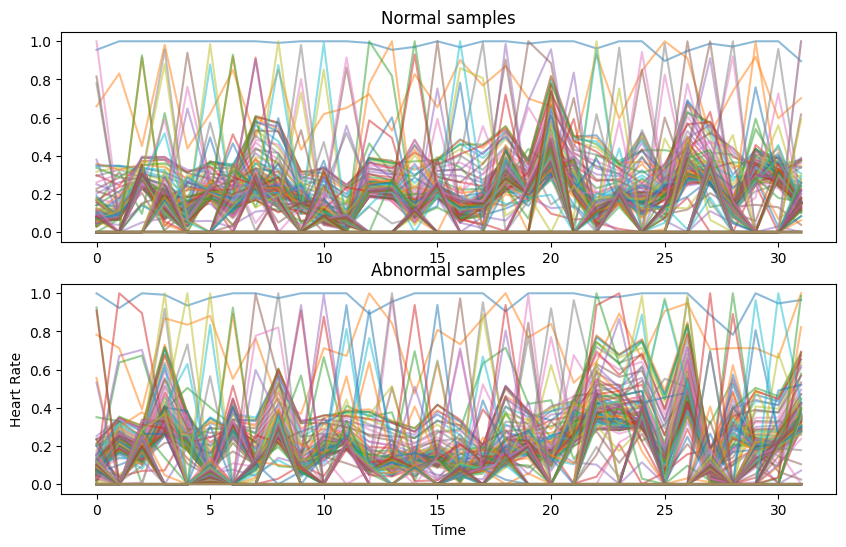

In [3]:
import matplotlib.pyplot as plt

# Initialize a plot
fig = plt.figure(figsize=(10, 6))

XN, X2 = next(trainstreamerVAE)
XA, X2 = next(validstreamerVAE)

XN = XN.view(XN.size(0), -1) 
XA = XA.view(XA.size(0), -1) 

ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

ax1.plot(XN, alpha=0.5)
ax1.set_title('Normal samples')

ax2.plot(XA, alpha=0.5)
ax2.set_title('Abnormal samples')


plt.xlabel('Time')
plt.ylabel('Heart Rate')

# Show plot
plt.show()

In [4]:
X1, X2 = next(trainstreamerVAE)

encoder = rae_model.Encoder()
decoder = rae_model.Decoder()

logger.info(f"the shape before : {X1.shape}")

latent = encoder(X1)
logger.info(f"the latent shape : {latent.shape}")

x = decoder(latent)
logger.info(f"the shape after: {x.shape}")

lossfn = rae_model.ReconstructionLoss()
loss = lossfn(x, X2)
logger.info(f"Untrained loss: {loss}")

logger.info(f"starting training for {200} epochs")
autoencoder = rae_model.RecurrentAutoencoder()

settings = TrainerSettings(
    epochs=200,
    metrics=[lossfn],
    logdir="logs",
    train_steps=200,
    valid_steps=200,
    reporttypes=[ReportTypes.TENSORBOARD],
    earlystop_kwargs = {
        "save": False,
        "verbose": True,
        "patience": 10,
    },
    optimizer_kwargs = {"lr": 1e-4},
    scheduler_kwargs={"factor": 0.1, "patience": 5},
)

trainer = Trainer(
    model=autoencoder,
    settings=settings,
    loss_fn=lossfn,
    optimizer=torch.optim.Adam,
    traindataloader=trainstreamerVAE,
    validdataloader=teststreamerVAE,
    scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
)
trainer.loop()

2024-06-26 11:59:27.792 | INFO     | __main__:<module>:6 - the shape before : torch.Size([32, 192, 1])
2024-06-26 11:59:27.871 | INFO     | __main__:<module>:9 - the latent shape : torch.Size([32, 24])
2024-06-26 11:59:27.887 | INFO     | __main__:<module>:12 - the shape after: torch.Size([32, 192, 1])
2024-06-26 11:59:27.889 | INFO     | __main__:<module>:16 - Untrained loss: 23.769290924072266
2024-06-26 11:59:27.890 | INFO     | __main__:<module>:18 - starting training for 200 epochs
2024-06-26 11:59:27.897 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/20240626-115927


2024-06-26 11:59:28.280 | INFO     | mltrainer.trainer:__init__:72 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|██████████| 200/200 [00:08<00:00, 22.62it/s]
2024-06-26 11:59:40.602 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 6.6638 test 4.2624 metric ['4.2624']
100%|██████████| 200/200 [00:08<00:00, 22.25it/s]
2024-06-26 11:59:51.970 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 4.2930 test 3.7177 metric ['3.7177']
100%|██████████| 200/200 [00:09<00:00, 22.08it/s]
2024-06-26 12:00:04.533 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 3.5886 test 2.3627 metric ['2.3627']
100%|██████████| 200/200 [00:09<00:00, 22.02it/s]
2024-06-26 12:00:16.991 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 2.3813 test 1.8008 metric ['1.8008']
100%|██████████| 200/200 [00:09<00:00, 21.02it/s]
2024-06-26 12:00:30.521 | INFO     | mltrainer.trainer:report:191 - Epoch 4 train 2.0520 test 1.6435 metric ['1.6435']
100%|██

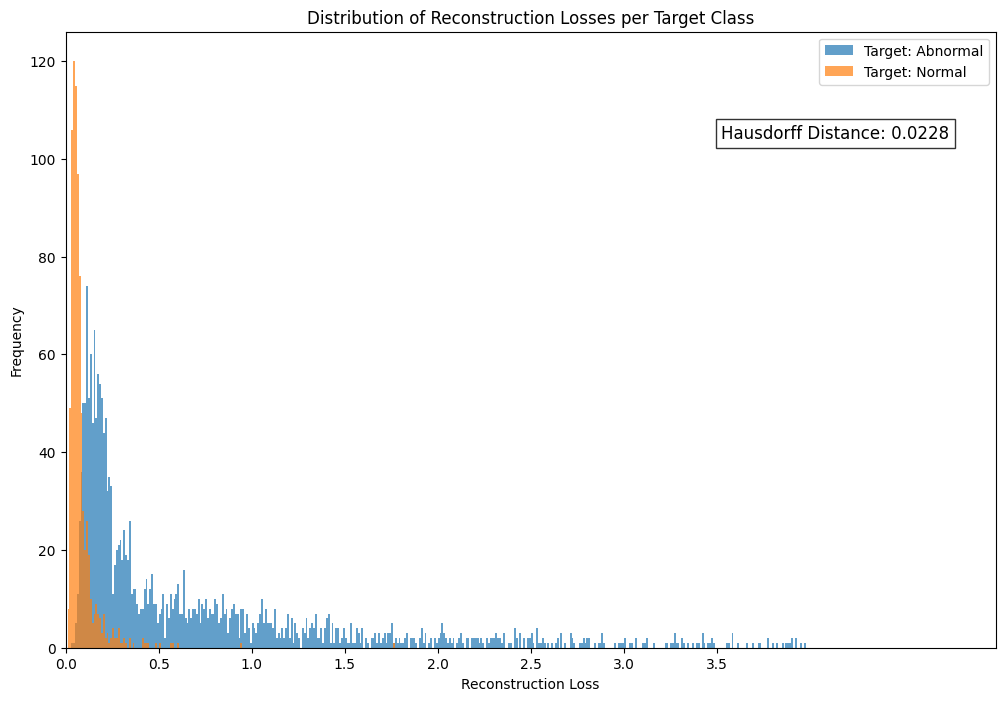

In [5]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from scipy.spatial.distance import directed_hausdorff

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def predict(autoencoder, dataset):
    predictions, losses = [], []
    criterion = rae_model.ReconstructionLoss()
    with torch.no_grad():
        autoencoder.eval()

        for input_sequence, target in dataset:
            # Ensure input_sequence has correct dimensions (batch_size, seq_len, n_features)
            input_sequence = input_sequence.unsqueeze(0).to(device)  # Add a dummy batch dimension

            seq_pred = autoencoder(input_sequence)
            loss = criterion(seq_pred, input_sequence.squeeze(0))  # Use input_sequence for calculating loss
            
            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())
    return predictions, losses

def plot_losses_per_target(dataset, autoencoder):
    losses_per_target = {}

    # Predict and accumulate losses per target
    _, all_losses = predict(autoencoder, dataset)
    for loss, (_, target) in zip(all_losses, dataset):
        target_class = "abnormal" if target.item() == 1 else "normal"
        if target_class not in losses_per_target:
            losses_per_target[target_class] = []
        losses_per_target[target_class].append(loss)

    # Calculate overlap using Hausdorff distance
    normal_losses = losses_per_target['normal']
    abnormal_losses = losses_per_target['abnormal']
    
    # Compute Hausdorff distance (can be other metrics like KL divergence, Jensen-Shannon divergence, etc.)
    overlap_distance = directed_hausdorff(np.array(normal_losses).reshape(-1, 1), np.array(abnormal_losses).reshape(-1, 1))[0]
    
    # Plotting
    fig, ax = plt.subplots(figsize=(12, 8))
    for target_class, loss_list in losses_per_target.items():
        ax.hist(loss_list, bins=np.arange(0, 4, 0.01), alpha=0.7, label=f'Target: {target_class.capitalize()}')
    
    ax.set_xticks(np.arange(0, 4, 0.5))
    ax.set_xticklabels(np.arange(0, 4, 0.5))
    ax.set_xlabel('Reconstruction Loss')
    ax.set_ylabel('Frequency')
    ax.set_title('Distribution of Reconstruction Losses per Target Class')
    ax.legend()

    # Set custom limits for x-axis (reconstruction loss)
    plt.xlim(0, 5)  # Adjust the limits as needed
    
    plt.text(0.95, 0.85, f'Hausdorff Distance: {overlap_distance:.4f}', transform=ax.transAxes,
             verticalalignment='top', horizontalalignment='right', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

    plt.show()

# Assuming validsdatasetVAE is your dataset of sequences
plot_losses_per_target(validsdatasetVAE, autoencoder)



In [6]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm

# Assuming rae_model.ReconstructionLoss() is defined appropriately in your code

def calculate_metrics(dataset, autoencoder, threshold):
    predictions = []
    true_labels = []

    criterion = rae_model.ReconstructionLoss()

    with torch.no_grad():
        autoencoder.eval()
        for input_sequence, target in dataset:
            input_sequence = input_sequence.unsqueeze(0)
            target = target.item()
            true_labels.append(target)
            seq_pred = autoencoder(input_sequence)
            loss = criterion(input_sequence.squeeze(0), seq_pred)

            predictions.append(1 if loss > threshold else 0)

    true_labels = np.array(true_labels)
    predictions = np.array(predictions)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(true_labels, predictions)

    # Compute precision, recall, and F1 score
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)

    return conf_matrix, precision, recall, f1

# Function to find best threshold based on F1 score
def find_best_threshold(dataset, autoencoder):
    thresholds = np.arange(0, 0.5, 0.01)  # Define a range of thresholds to test
    best_threshold = None
    best_f1 = -1
    results = []

    # Initialize tqdm progress bar
    progress_bar = tqdm(thresholds, desc='Finding Best Threshold', leave=True)
    
    for threshold in progress_bar:
        _, precision, recall, f1 = calculate_metrics(dataset, autoencoder, threshold)
        
        # Update best threshold if current F1 score is higher
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
        
        # Update progress bar description
        progress_bar.set_postfix({'Best F1': best_f1, 'Current Threshold': threshold})
        
        # Append current threshold search result to list
        results.append([threshold, precision, recall, f1])
    
    # Close tqdm progress bar
    progress_bar.close()

    return best_threshold, best_f1, results

# Example usage:
# Assuming validsdatasetVAE is your dataset of sequences
best_threshold, best_f1, threshold_results = find_best_threshold(validsdatasetVAE, autoencoder)
print(f"Best Threshold: {best_threshold:.2f}")
print(f"Best F1 Score: {best_f1:.4f}")

# Print threshold search results as table
print("\nThreshold Search Results:")
print("\nThreshold\tPrecision\tRecall\t\tF1 Score")
for result in threshold_results:
    print(f"{result[0]:.2f}\t\t{result[1]:.4f}\t\t{result[2]:.4f}\t\t{result[3]:.4f}")


Finding Best Threshold: 100%|██████████| 50/50 [07:45<00:00,  9.31s/it, Best F1=0.938, Current Threshold=0.49]

Best Threshold: 0.09
Best F1 Score: 0.9382

Threshold Search Results:

Threshold	Precision	Recall		F1 Score
0.00		0.7231		1.0000		0.8393
0.01		0.7231		1.0000		0.8393
0.02		0.7251		1.0000		0.8407
0.03		0.7376		1.0000		0.8490
0.04		0.7659		0.9995		0.8673
0.05		0.8008		0.9990		0.8890
0.06		0.8372		0.9967		0.9100
0.07		0.8703		0.9914		0.9269
0.08		0.8976		0.9791		0.9366
0.09		0.9155		0.9620		0.9382
0.10		0.9255		0.9382		0.9318
0.11		0.9327		0.9145		0.9235
0.12		0.9425		0.8793		0.9098
0.13		0.9504		0.8551		0.9002
0.14		0.9539		0.8266		0.8857
0.15		0.9554		0.8048		0.8736
0.16		0.9577		0.7739		0.8560
0.17		0.9617		0.7515		0.8437
0.18		0.9646		0.7249		0.8278
0.19		0.9671		0.6993		0.8117
0.20		0.9680		0.6751		0.7954
0.21		0.9718		0.6542		0.7819
0.22		0.9722		0.6318		0.7659
0.23		0.9737		0.6166		0.7551
0.24		0.9738		0.6000		0.7425
0.25		0.9746		0.5843		0.7306
0.26		0.9775		0.5791		0.7273
0.27		0.9788		0.5710		0.7213
0.28		0.9801		0.5615		0.7140
0.29		0.9831		0.5515		0.7066
0.30		0.9836		0.5411		

In [19]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import itertools
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# Assuming rae_model.ReconstructionLoss() is defined appropriately in your code

def calculate_metrics(dataset, autoencoder, threshold):
    predictions = []
    losses = []
    true_labels = []

    criterion = rae_model.ReconstructionLoss()

    with torch.no_grad():
        autoencoder.eval()
        for input_sequence, target in dataset:
            input_sequence = input_sequence.unsqueeze(0)
            target = target.item()
            true_labels.append(target)
            seq_pred = autoencoder(input_sequence)
            loss = criterion(input_sequence.squeeze(0), seq_pred)

            losses.append(loss.item())
            predictions.append(1 if loss > threshold else 0)

    true_labels = np.array(true_labels)
    predictions = np.array(predictions)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(true_labels, predictions)

    # Compute precision, recall, and F1 score
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)

    return conf_matrix, precision, recall, f1

# Calculate mean and standard deviation of normal heart sample reconstruction losses
def calculate_threshold(dataset, autoencoder):
    normal_losses = []
    criterion = rae_model.ReconstructionLoss()

    with torch.no_grad():
        autoencoder.eval()
        for input_sequence, target in dataset:
            input_sequence = input_sequence.unsqueeze(0)
            target = target.item()
            if target == 0:  # Assume target 0 represents normal samples
                seq_pred = autoencoder(input_sequence)
                loss = criterion(input_sequence.squeeze(0), seq_pred)
                normal_losses.append(loss.item())

    mean_loss = np.mean(normal_losses)
    std_loss = np.std(normal_losses)
    threshold = 0.07
    #threshold = mean_loss + 2 * std_loss  # 2 standard deviations above the mean

    return threshold

# Example usage:
# Assuming validsdatasetVAE is your dataset of sequences
threshold = calculate_threshold(validsdatasetVAE, autoencoder)
conf_matrix, precision, recall, f1 = calculate_metrics(validsdatasetVAE, autoencoder, threshold)

# Plot confusion matrix
def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title('Confusion Matrix')
    plt.colorbar()

    classes = ['Normal', 'Anomaly']
    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    thresh = conf_matrix.max() / 2.
    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

plot_confusion_matrix(conf_matrix)

plt.show()

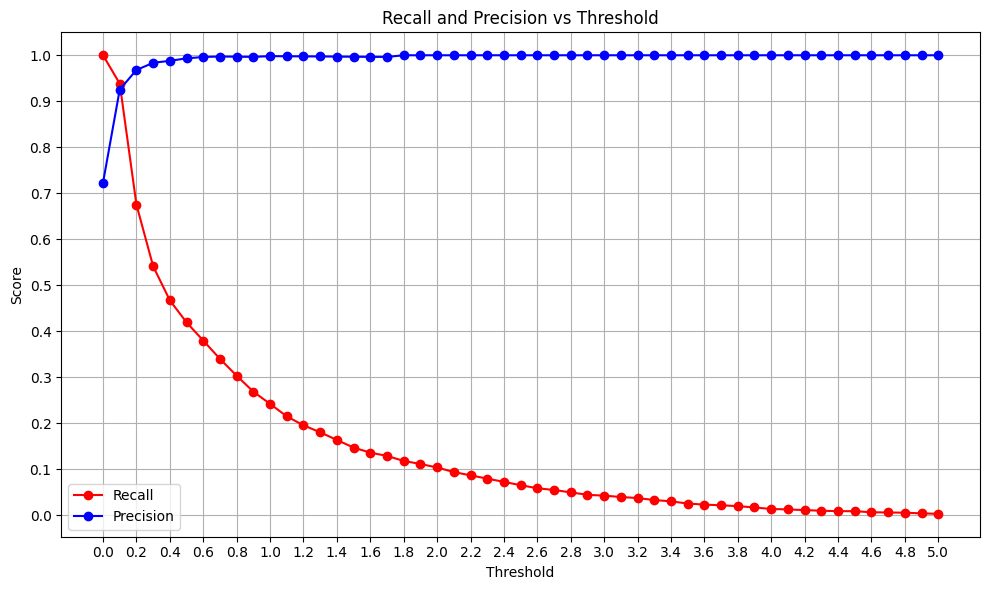

In [8]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

# Assuming this function is defined in your code to predict reconstruction losses
def predict(autoencoder, dataset):
    predictions, losses = [], []
    criterion = rae_model.ReconstructionLoss()  # Example criterion, adjust as per your actual loss function
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    with torch.no_grad():
        autoencoder.eval()

        for input_sequence, target in dataset:
            input_sequence = input_sequence.unsqueeze(0).to(device)
            seq_pred = autoencoder(input_sequence)
            loss = criterion(seq_pred, input_sequence.squeeze(0))
            
            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())  # Store the loss as a float
            
    return predictions, losses

def calculate_recall_and_precision(dataset, autoencoder):
    predictions, losses = predict(autoencoder, dataset)
    thresholds = np.arange(0, 5.1, 0.1)
    recall = []
    precision = []
    
    for threshold in thresholds:
        true_positive = 0
        total_true_anomalies = 0
        total_predicted_positives = 0
        
        for pred, loss, (_, target) in zip(predictions, losses, dataset):
            actual = target.item()

            # Count total true anomalies (target 1)
            if actual == 1:
                total_true_anomalies += 1

                # Check if any reconstruction loss is greater than the threshold
                if loss > threshold:
                    true_positive += 1

        # Count total predicted positives (samples with reconstruction loss > threshold)
        total_predicted_positives = sum(1 for l in losses if l > threshold)

        # Calculate precision and recall for the current threshold
        if total_true_anomalies == 0:
            recall.append(0)
        else:
            recall.append(true_positive / total_true_anomalies)

        if total_predicted_positives == 0:
            precision.append(0)
        else:
            precision.append(true_positive / total_predicted_positives)
    
    return recall, precision, thresholds

def plot_recall_and_precision(recall, precision, thresholds):
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, recall, marker='o', linestyle='-', color='r', label='Recall')
    plt.plot(thresholds, precision, marker='o', linestyle='-', color='b', label='Precision')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Recall and Precision vs Threshold')
    plt.xticks(np.arange(0, 5.1, 0.2))
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Assuming validsdatasetVAE is your dataset of sequences
recall, precision, thresholds = calculate_recall_and_precision(validsdatasetVAE, autoencoder)
plot_recall_and_precision(recall, precision, thresholds)


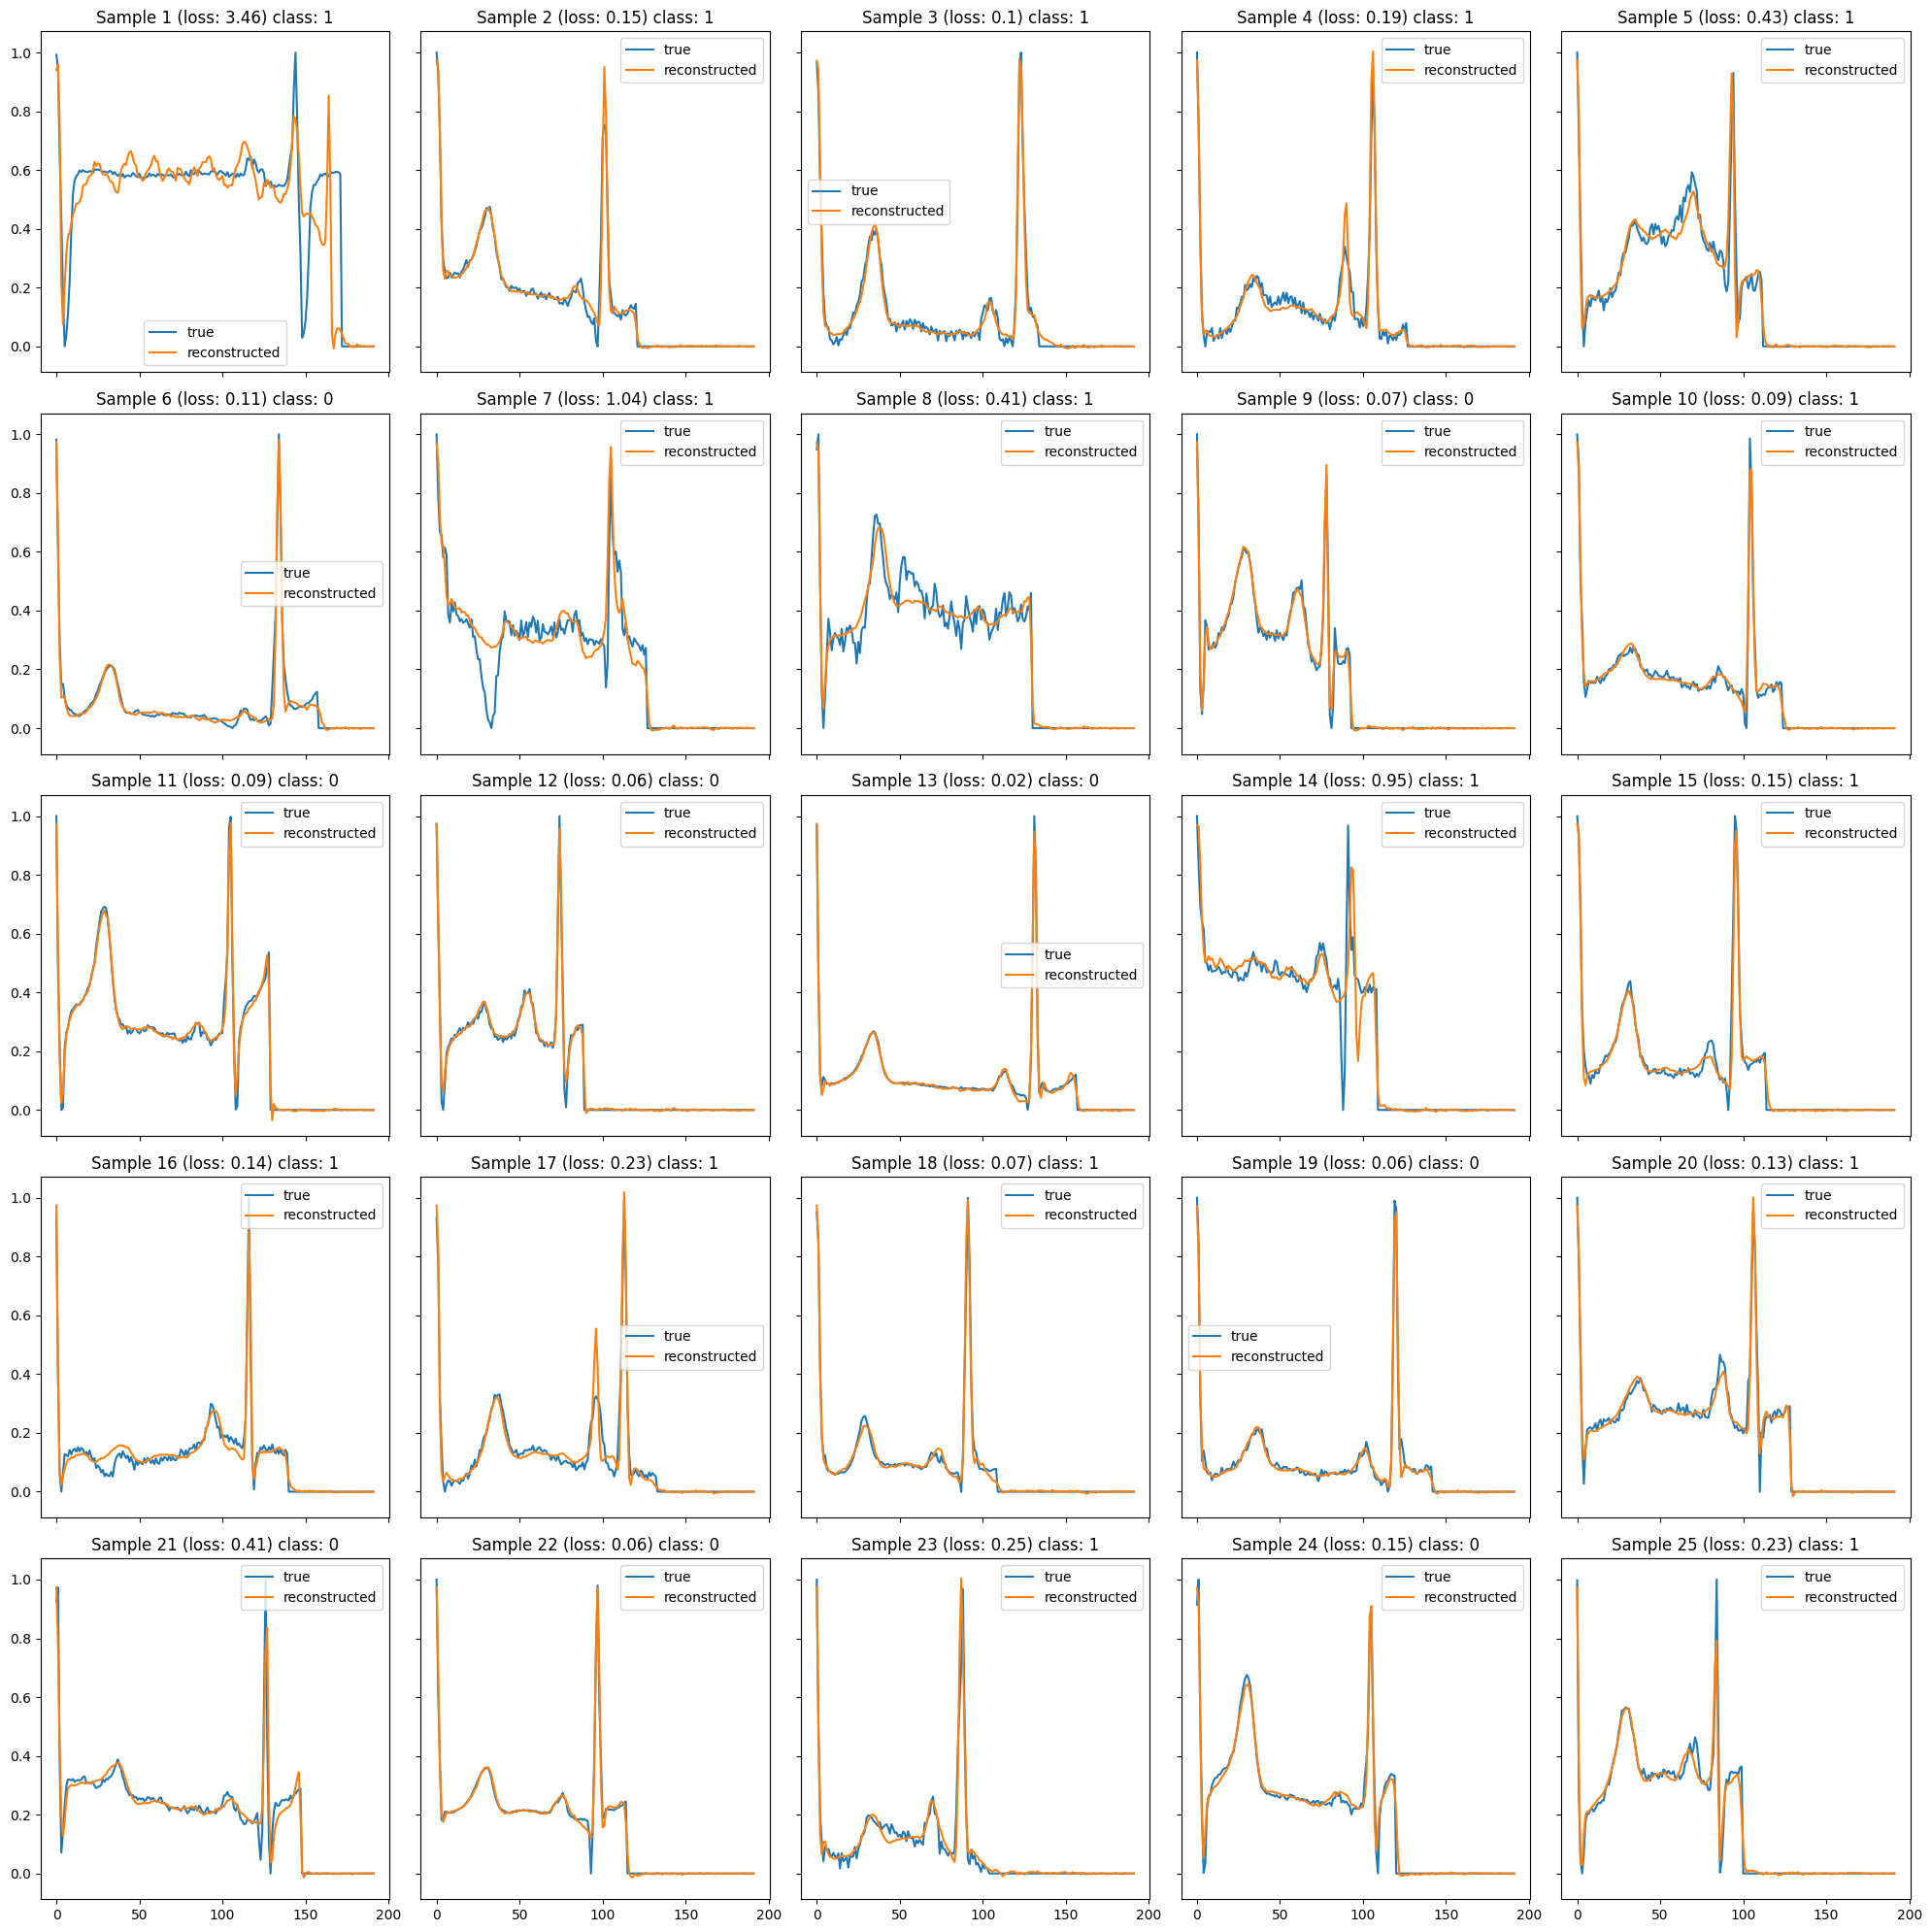

In [9]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def predict(autoencoder, dataset):
    predictions, losses = [], []
    criterion = rae_model.ReconstructionLoss()
    with torch.no_grad():
        autoencoder.eval()
        for input_sequence, target in dataset:
            # Ensure input_sequence has correct dimensions (batch_size, seq_len, n_features)
            input_sequence = input_sequence.unsqueeze(0).to(device)  # Add a dummy batch dimension

            seq_pred = autoencoder(input_sequence)
            loss = criterion(seq_pred, input_sequence.squeeze(0))  # Use input_sequence for calculating loss
            
            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())
    return predictions, losses

def plot_prediction(data, autoencoder, title, ax):
    predictions, pred_losses = predict(autoencoder, [data])  # Pass encoder, decoder, and dataset
    
    input_sequence, target = data  # Extract input_sequence from the tuple
    data_np = input_sequence.cpu().numpy().flatten()  # Convert to NumPy array and flatten
    predictions_np = predictions[0].flatten()  # Flatten predictions
    
    ax.plot(data_np, label='true')
    ax.plot(predictions_np, label='reconstructed')
    ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)}) class: {target.item()}')
    ax.legend()

# Assuming validsdatasetVAE is your dataset of sequences
fig, axs = plt.subplots(
    nrows=5,  # 5 rows of plots
    ncols=5,  # 5 columns of plots
    sharey=True,
    sharex=True,
    figsize=(20, 20)  # Larger figure size for better readability
)

num_samples = 25  # Total number of samples to plot
random_indices = random.sample(range(len(validsdatasetVAE)), num_samples)

# Collect the samples
samples = [validsdatasetVAE[idx] for idx in random_indices]

for i, data in enumerate(samples):
    plot_prediction(data, autoencoder, title=f'Sample {i+1}', ax=axs[i // 5, i % 5])  # Pass encoder and decoder
  
fig.tight_layout()
plt.show()


After trying and changing layers and tweaking paramaters for days, I give up!
The autoencoder, sees a lot of abnormal heart rates as normal heart rates as shown in the above figures.
I squeezed the latent space to the most narrow variant and still no luck. I think to make it work, some way of penalizing the model for making reconstruction errors hard by abnormal heart rates.
Probably this could be done, by making it a supervised learning algorithm and using the actual label for penalizing the model harder.

Taking time in consideration, I quit this way and take another one.

Because of all the hours I put in this piece of art, I still keep the code (maybe for the next generation) and reference to it in the paper.
Maybe it will work some day.